***
# Deriving the SLIM forcing file (in progress...)

# Modified following Marysa Lague's code "pres_vs_hist_alb_LN_postAGU20190621_corrected_rs.ipynb"
   * Updated on Sunday Oct 18 2020 by Wenwen Kong
***

***
# References
   *  [Laguë et al., 2019, Separating the impact of individual land surface properties on the terrestrial surface energy budget in both the coupled and un-coupled land-atmosphere system](https://journals.ametsoc.org/jcli/article/32/18/5725/344078/Separating-the-Impact-of-Individual-Land-Surface)
   * CLM 5.0 documentation [html](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/index.html), [pdf](http://www.cesm.ucar.edu/models/cesm2/land/CLM50_Tech_Note.pdf)
   * [LSM 1.0 documentation](https://opensky.ucar.edu/islandora/object/technotes:185)
***

***
# About this notebook

   * This notebook derives a SLIM input forcing file, which will be used for a CAM6-SLIM coupled simulation (fixed SST, F2000 configuration). To this end, we need a CLM output that can represent key land surface properties around year 2000. 
   * We use the model results from the CMIP6-AMIP simulations, which was integrated from 1950 to 2015, with 10 ensemble members in total. We use the climatology of 1991-2010 to present the baseline climatology for our F2000 SLIM run. [This page](https://svn-cesm2-expdb.cgd.ucar.edu/public/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001/) provides detailed case info for these CMIP6-AMIP runs. 
   * In this particular notebook, we derive the SLIM input from the model output of ensemble member #001. Later on, we will repeat the following calculations to derive the input from the ensemble mean from #001 to #010. 
   * The CMIP6-AMIP output can be obtained from 
       * NCAR's Cheyenne cluster: /glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001/
       * [Earth System Grid](https://www.earthsystemgrid.org/dataset/ucar.cgd.cesm2.f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.html)
   * Besides the CMIP6-AMIP model output, we will need information from the below files, both were used to initialize the CMIP6-AMIP runs.
       * domain file: domain.lnd.fv0.9x1.25_gx1v7.151020.nc
           * The domain file provides landmask information
       * surfdata: surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc
           * The surfdata provides 'PCT_GLACIER' and 'zbedrock'. The former will be used to derive 'glc_mask' for SLIM, and the latter might be useful when we drive the soil water capacity (i.e. 'bucketdepth' for SLIM). 
           * Note that in this notebook, we directly read two data files that contain 'PCT_GLACIER' and 'zbedrock' respectively. This is because the raw surfdata does not contain latitude and longitude coordinate information, so we re-created the two data files with full metadata info, which will make the visualization easier. 
           * Eventually, we should solve this minor issue and allow the users to read in the raw surfdata and assign the lat and lon info to variables in the surfdata. 
***

***
# About SLIM
   * The SLIM (Simple Land Interface Model) was deveoped by [Dr. Marysa Laguë](https://marysalague.com).
   * The official reference for SLIM is [Laguë et al., 2019](https://journals.ametsoc.org/jcli/article/32/18/5725/344078/Separating-the-Impact-of-Individual-Land-Surface).
   * The source code of SLIM is provided [here](https://github.com/marysa/SimpleLand) on github. In that repository, you can find a [SLIM wiki](https://github.com/marysa/SimpleLand/wiki) that Marysa wrote for interested users.
***

***
# Variables needed from the CLM output 

| Tag | Longname | Units | Notes|
| --- | --- | --- | ---|
| FSR |reflected solar radiation | W/m^2| |
| FSDS|atmospheric incident solar radiation |W/m^2| |
| GSSHA | shaded leaf stomatal conductance | umol H2O/m2/s | |
| GSSUN | sunlit leaf stomatal conductance | umol H2O/m2/s | | 
| GSSHALN | shaded leaf stomatal conductance at local noon | umol H2O/m2/s | |
| GSSUNLN | sunlit leaf stomotal conductance at local noon | umol H2O/m2/s | |
| TLAI | total projected leaf area index | m^2/m^2 | |
| HTOP | canopy top | m | | 
| LAISUN | sunlit projected leaf area index | m^2/m^2 | | 
| LAISHA | shaded projected leaf area index | m^2/m^2 | | 
| SNOW_DEPTH | snow height of snow covered area | m | | 
| FSRND | direct nir reflected solar radiation | W/m^2| |
| FSRNI | diffuse nir reflected solar radiation | W/m^2 | |
| FSRVD | direct vis reflected solar radiation | W/m^2 | |
| FSRVI | diffuse vis reflected solar radiation | W/m^2 | |
| FSDSND | direct nir incident solar radiation | W/m^2 | |
| FSDSNI | diffuse nir incident solar radiation | W/m^2 | |
| FSDSVD | direct vis incident solar radiation | W/m^2 | |
| FSDSVI | diffuse vis incident solar radiation | W/m^2 | |

***

***
# Typical variables in the SLIM input 

  * Table 1 from Supplemental Material for "Separating the impact of individual land surface properties on the terrestrial surface energy budget in both the coupled and un-coupled land-atmosphere system" by [Laguë et al., 2019](https://journals.ametsoc.org/jcli/article/32/18/5725/344078/Separating-the-Impact-of-Individual-Land-Surface);
  * The table below is the same as [Laguë et al., 2019](https://journals.ametsoc.org/jcli/article/32/18/5725/344078/Separating-the-Impact-of-Individual-Land-Surface). Note that this table presents an idealized case, meaning that neither seasonality nor spatial variation was considered. Users can use this table as a reference of meaning, units, and typical values of each SLIM input variable.

    
| Tag | Description | Typical value |Units | Notes|
| --- | --- | --- | ---| --- |
| glc_mask | Mask marking gridcells which should be treated as glaciers/ice sheets | logical | unitless | Reading "PCT_GLACIER" from CLIM surfdata and set regions with PCT_GLACIER >=50 to 1 |
| alb_gvd | Visible direct albedo for bare ground | 0.2 | unitless | |
| alb_svd | Visible direct albedo for deep snow | 0.8 | unitless | |
| alb_gnd | Near-infrared direct albedo for bare ground | 0.3 | unitless | |
| alb_snd | Near-infrared direct albedo for deep snow | 0.6 | unitless | |
| alb_gvf | Visible diffuse albedo for bare ground | 0.2 | unitless | |
| alb_svf | Visible diffuse albedo for deep snow | 0.8 | unitless | |
| alb_gnf | Near-infrared diffuse albedo for bare ground | 0.3 | unitless | |
| alb_snf | Near-infrared diffuse albedo for deep snow | 0.6 | unitless | |
| bucketdepth | Bucket capacity: maximum amount of water the soil can hold | 200 | kg/m2 = mm | TODO |
| emissivity | Surface emissivity for longwave radiation | 0.9-1.0 | unitless | Set to 1|
| snowmask | Snow-masking depth: mass of water required in snow bucket to fully mask the bare ground albedo | 50 | kg/m^2 | |
| roughness | Vegetation height; used to calculate roughness lengths for momentum and heat | | m | 'HTOP' from CLM output |
| evap_res | "Lid" resistance to evaporation | 1000 | s/m | Calculated following Lague et al. 2019 | 
| l2xavg_Fall_flxdst1 | 
| l2xavg_Fall_flxdst2 |
| l2xavg_Fall_flxdst3 |
| l2xavg_Fall_flxdst4 | 
| soil_type | Currently useless | | | Set to zero |
| soil_tk_1d | Thermal conductivity of soil (used for whole column) | 1.5 | W/m/K | TODO|
| soil_cv_1d | Heat capacity of soil (used for whole column where glaciated) | 2.4 | J/m3/K | TODO
| glc_tk_1d | Thermal conductivity of ice (used for whole column where glaciated) | 2.4 | W/m/K | TODO |
| glc_cv_1d | Heat capacity of ice (used for whole column where glaciated) | 1.9e6 | J/m3/K | TODO |


# We derive these variables following the below sequence.
## [A. 'glc_mask'](#A.-deriving-'glc_mask')
  * **Question:** we read 'PCT_GLACIER' from the CLM initial surfdata and mask regions with 'PCT_GLACIER'>=50% as glacial regions in SLIM. By doing so, we keep the glaical extent fixed across the whole year. To match the CLM, we may need to consider seasonal variation of the spatial coverage of land ice in SLIM? However, I did not find a variable that could tell us this information. Both 'snowfrac' from CICE output and 'ICEFRAC' from CAM only covers sea ice information. How to figure out the land ice info? 

## [B. albedo](#B.-deriving-albedo)
  * **Question:**
      * **alb_gvd**: the annual mean global mean value of mine calculated alb_gvd is close to 1, but the typical value provided in Marysa's paper suggests a typical value of 0.2. So need to double check my calculation.
      * The rest ground albedos also have averaged value exceeding 0.5, which is also too high. 

## [C. 'bucketdepth'](#C.-deriving-'bucketdepth')
  * **Question:**
      * Which variable from the CLM output can tell us the total (or maximum) water content in soil? We found several potential candidate variables, but unsure which fits our purpose. For the one that seems most relevant, i.e. TOTSOILLIQ, the magnitude is much larger than the typical value suggested by Lague et al. 2019.
      * Lague et al. 2019 used a value of 200 kg/m2 and mentioned this value is equivalent to a 1 meter deep 'bucket'. Why 200 kg/m2 = 1m bucket, shouldn't it be 2 m?

## [D. 'emissivity'](#D.-deriving-'emissivity')
## [E. 'snowmask'](#E.-deriving-'snowmask')
## [F. 'roughness'](#F.-deriving-'roughness')
## [G. 'evap_res'](#G.-deriving-'evap_res')
## [H. dust fluxes](#H.-deriving-dust-fluxes)
## [I. 'soil type'](#I.-deriving-'soil-type')
## [J. soil thermal properties](#J.-deriving-soil-thermal-properties)
## [K. glacier thermal properties](#K.-deriving-glacier-thermal-properties)
***

# Importing useful libs

In [1]:
%matplotlib inline 
import sys

# netcdf/numpy/xarray
import numpy as np
import netCDF4 as nc
import numpy.matlib
import datetime
import xarray as xr

from scipy import interpolate
from numpy import ma 
from scipy import stats

import scipy.io as sio
import pickle as pickle
from sklearn import linear_model
import numpy.ma as ma

import time

from copy import copy 

from joblib import Parallel, delayed
import multiprocessing

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker

from matplotlib.ticker import FormatStrFormatter

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import gridspec

# OS interaction
import os
import sys
import cftime

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

#from season_mean import season_mean

import matplotlib.colors as mcolors

import glob
import dask.array as da

import time as tm



# Define useful functions
  * To do - define useful functions for
      * Print out min and max values
      * Print out dimensions
      * Simple plots

***
# Load in required datafiles
 * CLM outputs (postprocessed by users)
     * f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.clm2.h0.1991-2010.clim.nc
 * domain file
     * domain.lnd.fv0.9x1.25_gx1v7.151020.nc
 * surfdata
     * surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc

In [19]:
path     ='/Users/wenwen/Research/POSTDOC/CMIP6-AMIP/'
casename = 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001.clm2.h0.1991-2010.clim.nc'
##### domain file ##### (accurate land masks that the coupler uses):
f_domain  = path + 'domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
nc_domain = xr.open_dataset(f_domain)
landmask  = np.where(nc_domain['mask']==1,1.0,np.nan)

##### CLM surfdata ##### 
f_surfdata = path + 'surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc'
nc_surfdata= xr.open_dataset(f_surfdata)

##### CLM zbedrock #####
f_zbedrock = path + 'surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824_zbedrock.nc'
nc_zbedrock= xr.open_dataset(f_zbedrock)

##### CLM PCT_GLACIER #####
f_PCT_GLACIER = path + 'surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824_PCT_GLACIER.nc'
nc_PCT_GLACIER= xr.open_dataset(f_PCT_GLACIER)

##### CLM outputs ##### 
##### (1991-2010 monthly climatology from CMIP6-AMIP ensemble #001)
f_CLM = path+'ensemble_001_CLM/'+casename
nc_CLM= xr.open_dataset(f_CLM)

##### latitudes and longitudes grids 
lat_clm = nc_CLM.variables['lat'].values[:]
lon_clm = nc_CLM.variables['lon'].values[:]


# Var list from CLM  
  * The var list is currently useless in this notebook

In [3]:
lndvars = ['FSR','FSDS','GSSHA','GSSUN','GSSHALN','GSSUNLN','TLAI','HTOP',
           'LAISUN','LAISHA','SNOW_DEPTH',
           'FSRND','FSRNI','FSRVD','FSRVI',
           'FSDSND','FSDSNI','FSDSVD','FSDSVI']

***
# Deriving the SLIM input
## We first create an empty array "nc_data" to store all the derived varibles

In [4]:
nc_data = {}

##### create a dummy array of ones to extend a lat x lon array into (time, lat, lon)
##### this will only be used if we set the 12 months to be the same pattern
##### currently, I think it can only be applied to glc_mask and soil_type
##### if we want to consider the seasonal cycle of glacial extent, we should only apply this to soil_type

dims    = np.shape(landmask)
stretch = np.ones([12, dims[0], dims[1]])
stretch.shape

(12, 192, 288)

***
## A. deriving 'glc_mask' 

| Tag | Description | Typical value |Units | Notes|
| --- | --- | --- | ---| --- |
| glc_mask | Mask marking gridcells which should be treated as glaciers/ice sheets | logical | unitless | Reading "PCT_GLACIER" from CLIM surfdata and set regions with PCT_GLACIER >=50 to 1 |


## `HOW TO:` 
   1. Read PCT_GLACIER from the surfdata
   2. Set grids where PCT_GLACIER >= 50% to 1

******* Plot of the original PCT_GLACIER ******


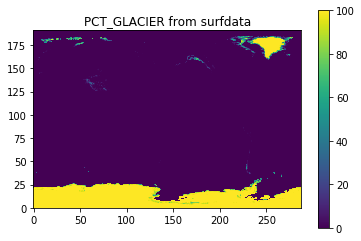

****** Plot of derived glc_mask ******


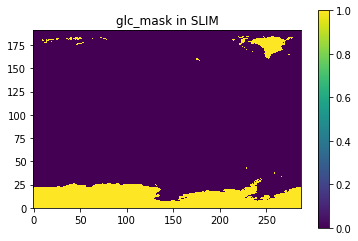

In [5]:
##### Get glacier mask
glc_pct = (nc_surfdata.variables['PCT_GLACIER']).values[:]

##### Apply the glacier mask where glc_pct >=50% 
glc_mask= np.zeros(np.shape(glc_pct))
glc_mask[ glc_pct >=50 ] = 1 

print("******* Plot of the original PCT_GLACIER ******")
plt.imshow(glc_pct, origin='lower'); plt.title('PCT_GLACIER from surfdata'); plt.colorbar();plt.show();

print("****** Plot of derived glc_mask ******")
plt.imshow(glc_mask, origin='lower'); plt.title('glc_mask in SLIM'); plt.colorbar();plt.show();

#nc_data['glc_mask'] = np.copy(stretch * glc_mask[:])
#nc_data['glc_mask'].shape

***
## B. deriving albedo 

| Tag | Description | Typical value |Units | Notes|
| --- | --- | --- | ---| --- |
| alb_gvd | Visible direct albedo for bare ground | 0.2 | unitless | |
| alb_svd | Visible direct albedo for deep snow | 0.8 | unitless | |
| alb_gnd | Near-infrared direct albedo for bare ground | 0.3 | unitless | |
| alb_snd | Near-infrared direct albedo for deep snow | 0.6 | unitless | |
| alb_gvf | Visible diffuse albedo for bare ground | 0.2 | unitless | |
| alb_svf | Visible diffuse albedo for deep snow | 0.8 | unitless | |
| alb_gnf | Near-infrared diffuse albedo for bare ground | 0.3 | unitless | |
| alb_snf | Near-infrared diffuse albedo for deep snow | 0.6 | unitless | |


## `HOW TO:`
   ### B1. We first calculate "ALBEDO, ALBEDO_ND, ALBEDO_NI, ALBEDO_VD, ALBEDO_VI" from CLM's radiation streams
   ### B2. We average each of the above values over a Greenland box to represent effective snow albedo (albedo of surfaces with 100% snow cover), which will be used for deep snow albedos in the SLIM input
   ### B3. We derive bare ground and deep snow albedos
***

## `Step by step:`

### [B1] We first calculate "ALBEDO, ALBEDO_ND, ALBEDO_NI, ALBEDO_VD, ALBEDO_VI" from CLM's radiation streams

In [6]:
##### Albedo = FSR / FSDS
# FSR = reflected solar radiation
# FSDS = atmospheric incident solar radiation
print("Deriving multistream albedo")
nc_albedo_temp = {}
nc_albedo_temp['ALBEDO'] = nc_CLM['FSR'] / nc_CLM['FSDS']
# Print the dimension 
print("Dimension is {} ".format(nc_albedo_temp['ALBEDO'].shape))
# Print the max and min for a quick sanity check
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo_temp['ALBEDO']),
                                                           np.amin(nc_albedo_temp['ALBEDO'])))
nc_albedo_temp['ALBEDO'].attrs['units'] = 'unitless'
nc_albedo_temp['ALBEDO'].attrs['longname'] = 'multistream albedo'

##### Near-IR direct albedo = FSRND / FSDSND
# FSRND = direct nir reflected solar radiation
# FSDSND = direct nir incident solar radiation
print("Deriving near-IR direct albedo")
nc_albedo_temp['ALBEDO_ND'] = nc_CLM['FSRND'] / nc_CLM['FSDSND']
print("Dimension is {} ".format(nc_albedo_temp['ALBEDO_ND'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo_temp['ALBEDO_ND']),
                                                           np.amin(nc_albedo_temp['ALBEDO_ND'])))
nc_albedo_temp['ALBEDO_ND'].attrs['units'] = 'unitless'
nc_albedo_temp['ALBEDO_ND'].attrs['longname'] = 'near-IR direct albedo'

##### Near-IR diffuse albedo
# FSRNI = diffuse nir reflected solar radiation
# FSDSNI = diffuse nir incident solar radiation
print("Deriving near-IR diffuse albedo")
nc_albedo_temp['ALBEDO_NI'] = nc_CLM['FSRNI'] / nc_CLM['FSDSNI']
print("Dimension is {} ".format(nc_albedo_temp['ALBEDO_NI'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo_temp['ALBEDO_NI']),
                                                           np.amin(nc_albedo_temp['ALBEDO_NI'])))
nc_albedo_temp['ALBEDO_NI'].attrs['units'] = 'unitless'
nc_albedo_temp['ALBEDO_NI'].attrs['longname'] = 'near-IR diffuse albedo'

##### Visible direct albedo 
# FSRVD = direct vis reflected solar radiation
# FSDSVD = direct vis incident solar radiation
print("Deriving visible direct albedo")
nc_albedo_temp['ALBEDO_VD'] = nc_CLM['FSRVD'] / nc_CLM['FSDSVD']
print("Dimension is {} ".format(nc_albedo_temp['ALBEDO_VD'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo_temp['ALBEDO_VD']),
                                                           np.amin(nc_albedo_temp['ALBEDO_VD'])))
nc_albedo_temp['ALBEDO_VD'].attrs['units'] = 'unitless'
nc_albedo_temp['ALBEDO_VD'].attrs['longname'] = 'visible direct albedo'

##### Visible diffuse albedo 
# FSRVI = diffuse vis reflected solar radiation
# FSDSVI = diffuse vis incident solar radiation
print("Deriving visible diffuse albedo")
nc_albedo_temp['ALBEDO_VI'] = nc_CLM['FSRVI'] / nc_CLM['FSDSVI']
print("Dimension is {} ".format(nc_albedo_temp['ALBEDO_VI'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo_temp['ALBEDO_VI']),
                                                           np.amin(nc_albedo_temp['ALBEDO_VI'])))
nc_albedo_temp['ALBEDO_VI'].attrs['units'] = 'unitless'
nc_albedo_temp['ALBEDO_VI'].attrs['longname'] = 'visible diffuse albedo'

Deriving multistream albedo
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(0.87404543) and minimum value is <xarray.DataArray ()>
array(0.05475887)
Deriving near-IR direct albedo
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(0.78832984) and minimum value is <xarray.DataArray ()>
array(0.05196042)
Deriving near-IR diffuse albedo
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(0.77789754) and minimum value is <xarray.DataArray ()>
array(0.05621005)
Deriving visible direct albedo
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(0.98996693) and minimum value is <xarray.DataArray ()>
array(0.02591079)
Deriving visible diffuse albedo
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(0.98054409) and minimum value is <xarray.DataArray ()>
array(0.03594067)


## [B2] We average each of the above values over a Greenland box to represent effective snow albedo (albedo of surfaces with 100% snow cover), which will be used for deep snow albedos in the SLIM input

  * We follow what Marysa did:
    > "To better match the coupled CLM runs, fish out the approximate snowy albedos from CLM. Take the average of the albedo over a box over greenland box:
    > lat (lat) float64 67.26 69.16 71.05 72.95 74.84
    > lon (lon) float64 315.0 317.5 320.0 322.5 325.0"
  * Note that Marysa calculated the snowy albedo from annual mean. Here, we keep the seasonality by assigning the January through December albedo values averaged over the Greenland box to each deep snow albedos in the SLIM input. 
  *  One may ask, is it reasonable to assign the Greenland values to the South Hemisphere as well? To address this concern, let's plot both Jan and July albedo over Greenland and the whole Globe for a quick comparison. 

### Global albedo
   * The below panel suggests that it is safe to use the Greenland values to represent global glacial regions' seasonal cycle. For example, comparing Greenland in Jan vs. Antarctica in July, and Greenland in July vs. Antarctica in Jan, the albedo value is about the same. 
   * The white patches over the northern half of Greenland in Jan and over Antarctica in July should be NaNs? I think it is related to the fact that there is no insolation in the polar region during winter. So it should not be a concern for us, because without insolation, it would not affect the energy fluxes whatever values we assign to those regions in winter.

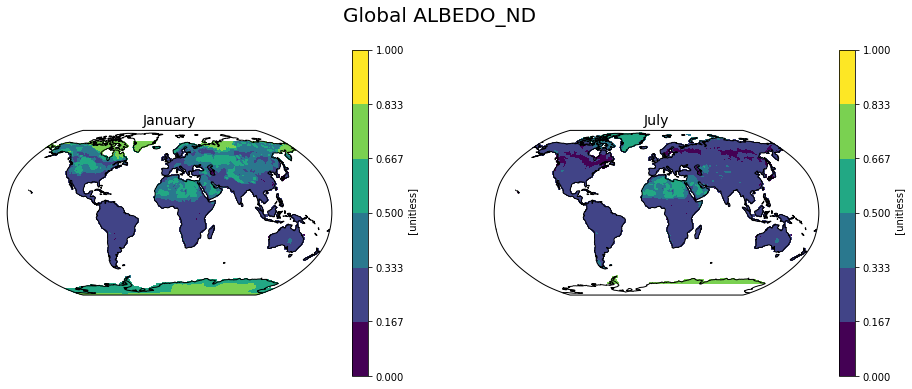

In [7]:
######################################################
########## Plot of Global ALBEDO_ND #################

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
nc_albedo_temp['ALBEDO_ND'][0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), vmin=0., vmax=1.0)
ax1.set_title('January', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
nc_albedo_temp['ALBEDO_ND'][6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
ax2.set_title('July', fontsize=14)

plt.suptitle('Global ALBEDO_ND', fontsize=20)
for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()


### Greenland albedo

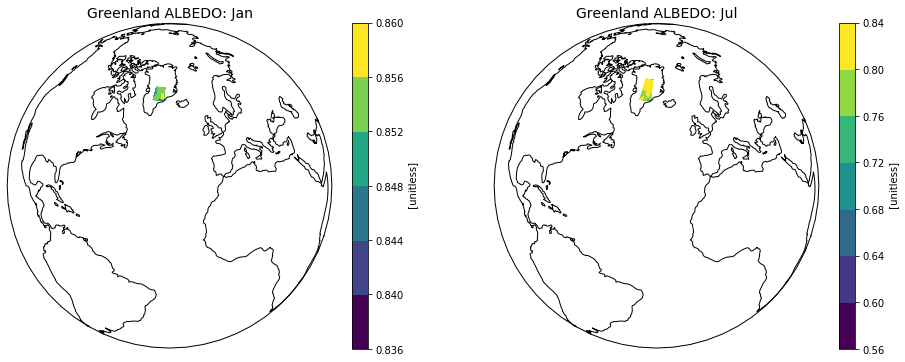

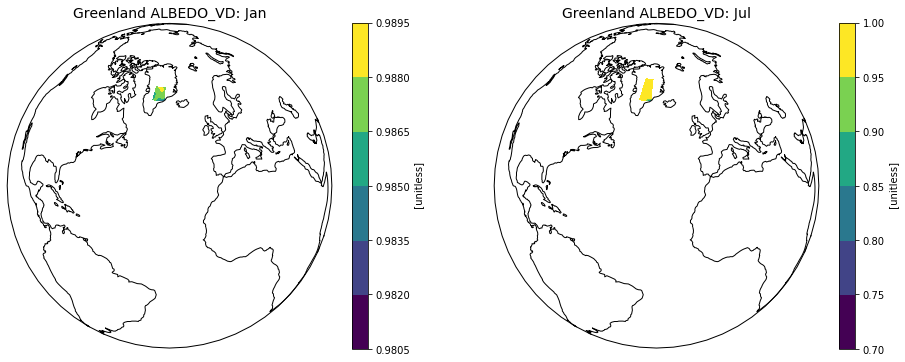

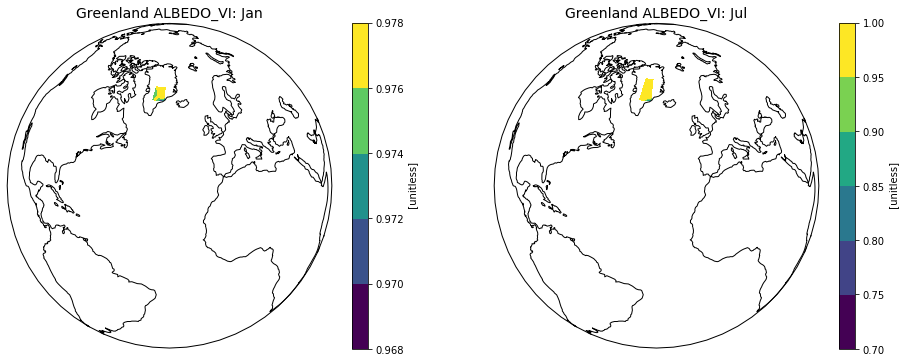

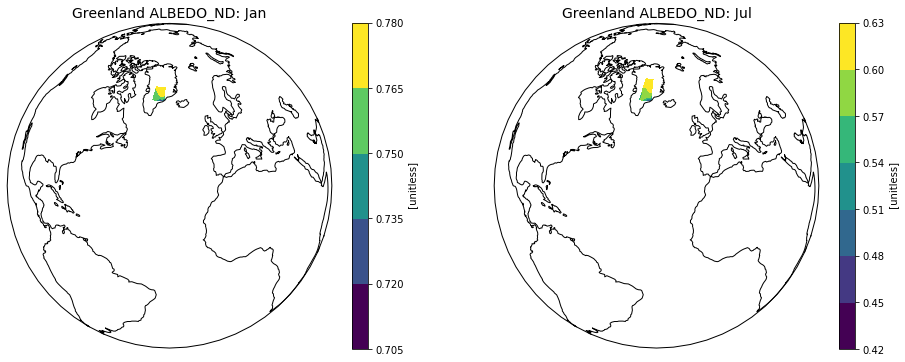

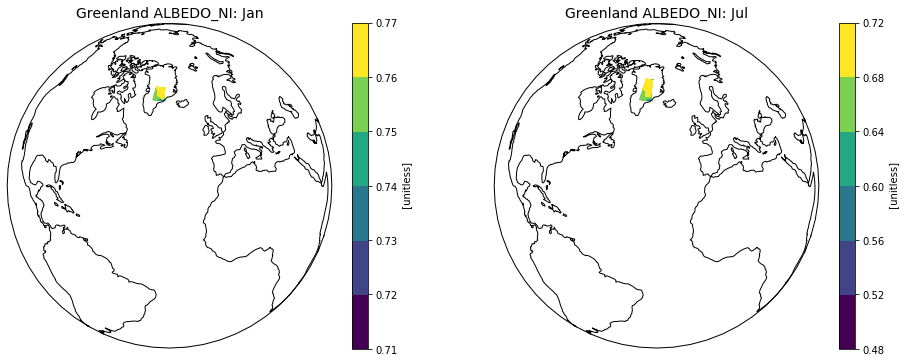

In [8]:
greenland_alb    = nc_albedo_temp['ALBEDO'].sel(lat=slice(66,76),lon=slice(315,325))#.mean('month')
greenland_alb_vd = nc_albedo_temp['ALBEDO_VD'].sel(lat=slice(66,76),lon=slice(315,325))#.mean('month')
greenland_alb_vi = nc_albedo_temp['ALBEDO_VI'].sel(lat=slice(66,76),lon=slice(315,325))#.mean('month')
greenland_alb_nd = nc_albedo_temp['ALBEDO_ND'].sel(lat=slice(66,76),lon=slice(315,325))#.mean('month')
greenland_alb_ni = nc_albedo_temp['ALBEDO_NI'].sel(lat=slice(66,76),lon=slice(315,325))#.mean('month')

greenland_alb.shape

######################################################
########## Plot of Greenland ALBEDO #################

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(-30,35))
greenland_alb[0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('Greenland ALBEDO: Jan', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Orthographic(-30,35))
greenland_alb[6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('Greenland ALBEDO: Jul', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()

######################################################
########## Plot of Greenland ALBEDO_VD ###############

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(-30, 35))
greenland_alb_vd[0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('Greenland ALBEDO_VD: Jan', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Orthographic(-30, 35))
greenland_alb_vd[6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('Greenland ALBEDO_VD: Jul', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()
    
######################################################
########## Plot of Greenland ALBEDO_VI ###############

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(-30, 35))
greenland_alb_vi[0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('Greenland ALBEDO_VI: Jan', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Orthographic(-30, 35))
greenland_alb_vi[6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('Greenland ALBEDO_VI: Jul', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()

######################################################
########## Plot of Greenland ALBEDO_ND ###############

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(-30, 35))
greenland_alb_nd[0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('Greenland ALBEDO_ND: Jan', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Orthographic(-30, 35))
greenland_alb_nd[6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('Greenland ALBEDO_ND: Jul', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()
    
######################################################
########## Plot of Greenland ALBEDO_NI ###############

fig   = plt.figure(figsize=(16,6))

ax1   = fig.add_subplot(1,2,1,projection=ccrs.Orthographic(-30, 35))
greenland_alb_ni[0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree())
ax1.set_title('Greenland ALBEDO_NI: Jan', fontsize=14)

ax2   = fig.add_subplot(1,2,2,projection=ccrs.Orthographic(-30, 35))
greenland_alb_ni[6,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree())
ax2.set_title('Greenland ALBEDO_NI: Jul', fontsize=14)

for ax in [ax1, ax2]:
    ax.set_global()
    ax.coastlines()

### Get the snow albedo for SLIM input by averaging over the Greenland box

### To do
    - Plot the seasonal cycle of the snow albedo

In [9]:
snow_alb = {}
print("****** Deriving snow_albedo VD ******")
snow_alb['vd']   = greenland_alb_vd.mean(dim={'lat','lon'})
print("Dimension is {} ".format(snow_alb['vd'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(snow_alb['vd']),
                                                           np.amin(snow_alb['vd'])))

print("****** Deriving snow_albedo VI ******")
snow_alb['vi']   = greenland_alb_vi.mean(dim={'lat','lon'})
print("Dimension is {} ".format(snow_alb['vi'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(snow_alb['vi']),
                                                           np.amin(snow_alb['vi'])))

print("****** Deriving snow_albedo ND ******")
snow_alb['nd']   = greenland_alb_nd.mean(dim={'lat','lon'})
print("Dimension is {} ".format(snow_alb['nd'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(snow_alb['nd']),
                                                           np.amin(snow_alb['nd'])))

print("****** Deriving snow_albedo NI ******")
snow_alb['ni']   = greenland_alb_ni.mean(dim={'lat','lon'})
print("Dimension is {} ".format(snow_alb['ni'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(snow_alb['ni']),
                                                           np.amin(snow_alb['ni'])))

****** Deriving snow_albedo VD ******
Dimension is (12,) 
Maximum value is <xarray.DataArray ()>
array(0.98679459) and minimum value is <xarray.DataArray ()>
array(0.9568584)
****** Deriving snow_albedo VI ******
Dimension is (12,) 
Maximum value is <xarray.DataArray ()>
array(0.97602916) and minimum value is <xarray.DataArray ()>
array(0.9507485)
****** Deriving snow_albedo ND ******
Dimension is (12,) 
Maximum value is <xarray.DataArray ()>
array(0.76262408) and minimum value is <xarray.DataArray ()>
array(0.58839506)
****** Deriving snow_albedo NI ******
Dimension is (12,) 
Maximum value is <xarray.DataArray ()>
array(0.76078516) and minimum value is <xarray.DataArray ()>
array(0.67416233)


## B3. We derive bare ground and deep snow albedos

### To do/confirm 
  * Confirm whether using 0.1 for ocean albedo is reasonable, this page(https://nsidc.org/cryosphere/seaice/processes/albedo.html) suggests a value of 0.06 for ocean albedo 
  * Marysa set the snow albedo to a single block of color, which is uniformly distributed across the whole globe and does not vary seasonally. Based on equation (14) in the SI of Lague et al. (2019), I think the purpose of this snow albedo is, its value at a certain grid box will be used when S>Ms or 0<S<Ms.
  * In below, we keep the seasonality of snow albedo, meaning that the value (taken from Greenland) varies from month to month. 

In [10]:
# Set ocean points to this generic value 
albedo_ocn = 0.1 

# Create alb to store 'ALBEDO_VD', 'ALBEDO_VI', 'ALBEDO_ND', 'ALBEDO_NI'
alb = {}
alb['vd'] = nc_albedo_temp['ALBEDO_VD']
alb['vi'] = nc_albedo_temp['ALBEDO_VI']
alb['nd'] = nc_albedo_temp['ALBEDO_ND']
alb['ni'] = nc_albedo_temp['ALBEDO_NI']

# Create nc_albedo to store ground and snow albedos
nc_albedo           = {}
nc_albedo['ground'] = {}
nc_albedo['snow']   = {}

# Now, let's put the albeo values to nc_albedo for ground and snow

for a in alb.keys():
    print("******* Deriving {} *******".format(a))
    for i in range(12):
        print ("    For the month of {}".format(i+1))
        # Assign ground value with raw values
        nc_albedo['ground'][a]        = alb[a]
    
        # Assign glacial regions with snow albedos 
        nc_albedo['ground'][a][i,:,:] = np.where(glc_mask==1., snow_alb[a][i], nc_albedo['ground'][a][i,:,:])
    
        # SLIM cannot initialize model with nans. Set nans to albedo_ocn = 0.1
        nc_albedo['ground'][a] = np.where(np.isnan(nc_albedo['ground'][a]), albedo_ocn, nc_albedo['ground'][a])
    
        # Assign snow albedo with the Greenland albedo
        # First assign ground albedo to nc_albedo['snow'] so it obtains the attributes
        nc_albedo['snow'][a]        = alb[a]
        nc_albedo['snow'][a][i,:,:] = snow_alb[a][i] 
        nc_albedo['snow'][a][i,:,:] = np.where(np.isnan(nc_albedo['snow'][a][i,:,:]), albedo_ocn, nc_albedo['snow'][a][i,:,:])


******* Deriving vd *******
    For the month of 1
    For the month of 2
    For the month of 3
    For the month of 4
    For the month of 5
    For the month of 6
    For the month of 7
    For the month of 8
    For the month of 9
    For the month of 10
    For the month of 11
    For the month of 12
******* Deriving vi *******
    For the month of 1
    For the month of 2
    For the month of 3
    For the month of 4
    For the month of 5
    For the month of 6
    For the month of 7
    For the month of 8
    For the month of 9
    For the month of 10
    For the month of 11
    For the month of 12
******* Deriving nd *******
    For the month of 1
    For the month of 2
    For the month of 3
    For the month of 4
    For the month of 5
    For the month of 6
    For the month of 7
    For the month of 8
    For the month of 9
    For the month of 10
    For the month of 11
    For the month of 12
******* Deriving ni *******
    For the month of 1
    For the month of 2
    F

## `Sanity check of the values (0.2-0.3 for ground, 0.6-0.8 for snow):`

### alb_gvd (visible direct albedo for bare ground):

In [18]:
nc_albedo['ground']['vd'].shape
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['ground']['vd']),
                                                           np.amin(nc_albedo['ground']['vd'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['ground']['vd'])))

***** alb_gvd (visible direct albedo for bare ground) *****
Maximum value is 0.9867945909500122 and minimum value is 0.029756737872958183
Annual averaged global mean value is 0.9127715229988098


(12, 192, 288)

### alb_svd (visible direct albedo for deep snow):

In [20]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['snow']['vd']),
                                                           np.amin(nc_albedo['snow']['vd'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['snow']['vd'])))

Maximum value is <xarray.DataArray ()>
array(0.98679459) and minimum value is <xarray.DataArray ()>
array(0.9568584)
Annual averaged global mean value is <xarray.DataArray ()>
array(0.97454035, dtype=float32)


### alb_gnd (Near-infrared direct albedo for bare ground):

In [21]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['ground']['nd']),
                                                           np.amin(nc_albedo['ground']['nd'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['ground']['nd'])))

Maximum value is 0.7626240849494934 and minimum value is 0.05332905054092407
Annual averaged global mean value is 0.6403440237045288


### alb_snd (Near-infrared direct albedo for deep snow):

In [22]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['snow']['nd']),
                                                           np.amin(nc_albedo['snow']['nd'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['snow']['nd'])))

Maximum value is <xarray.DataArray ()>
array(0.76262408) and minimum value is <xarray.DataArray ()>
array(0.58839506)
Annual averaged global mean value is <xarray.DataArray ()>
array(0.68382007, dtype=float32)


### alb_gvf (Visible diffuse albedo for bare ground):

In [23]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['ground']['vi']),
                                                           np.amin(nc_albedo['ground']['vi'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['ground']['vi'])))

Maximum value is 0.7607851624488831 and minimum value is 0.05829688534140587
Annual averaged global mean value is 0.682180643081665


### alb_svf (Visible diffuse albedo for deep snow)

In [24]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['snow']['vi']),
                                                           np.amin(nc_albedo['snow']['vi'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['snow']['vi'])))

Maximum value is <xarray.DataArray ()>
array(0.76078516) and minimum value is <xarray.DataArray ()>
array(0.67416233)
Annual averaged global mean value is <xarray.DataArray ()>
array(0.7242911, dtype=float32)


### alb_gnf (Near-infrared diffuse albedo for bare ground)

In [25]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['ground']['ni']),
                                                           np.amin(nc_albedo['ground']['ni'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['ground']['ni'])))

Maximum value is 0.7607851624488831 and minimum value is 0.05829688534140587
Annual averaged global mean value is 0.682180643081665


### alb_snf (Near-infrared diffuse albedo for deep snow)

In [26]:
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_albedo['snow']['ni']),
                                                           np.amin(nc_albedo['snow']['ni'])))
print('Annual averaged global mean value is {}'.format(np.mean(nc_albedo['snow']['ni'])))

Maximum value is <xarray.DataArray ()>
array(0.76078516) and minimum value is <xarray.DataArray ()>
array(0.67416233)
Annual averaged global mean value is <xarray.DataArray ()>
array(0.7242911, dtype=float32)


### Plot the bare ground and deep snow albedo for Jan and July for a quick check
   * AttributeError: 'numpy.ndarray' object has no attribute 'plot'
   * Hold off for drawing the derived bare ground and snow albedo

In [40]:
######################################################################
########## Plot of bare ground and deep snow albedos #################

#fig   = plt.figure(figsize=(16,6))
#fig.suptitle('January', fontsize=16)

#ax1   = fig.add_subplot(1,2,1,projection=ccrs.Robinson())
#nc_albedo['ground']['vd'][0,:,:].plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), vmin=0., vmax=1.0)
#ax1.set_title('ground_vd', fontsize=14)

#ax2   = fig.add_subplot(1,2,2,projection=ccrs.Robinson())
#nc_albedo['ground']['vi'][0,:,:].plot.contourf(ax=ax2, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax2.set_title('ground_vi', fontsize=14)

#ax3   = fig.add_subplot(2,4,3,projection=ccrs.Robinson())
#nc_albedo['ground']['nd'][0,:,:].plot.contourf(ax=ax3, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax3.set_title('ground_nd', fontsize=14)

#ax4   = fig.add_subplot(2,4,4,projection=ccrs.Robinson())
#nc_albedo['ground']['ni'][0,:,:].plot.contourf(ax=ax4, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax4.set_title('ground_ni', fontsize=14)

#ax5   = fig.add_subplot(2,4,5,projection=ccrs.Robinson())
#nc_albedo['snow']['vd'][0,:,:].plot.contourf(ax=ax5, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax5.set_title('snow_vd', fontsize=14)

#ax6   = fig.add_subplot(2,4,6,projection=ccrs.Robinson())
#nc_albedo['snow']['vi'][0,:,:].plot.contourf(ax=ax6, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax6.set_title('snow_vi', fontsize=14)

#ax7   = fig.add_subplot(2,4,7,projection=ccrs.Robinson())
#nc_albedo['snow']['nd'][0,:,:].plot.contourf(ax=ax7, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax7.set_title('snow_nd', fontsize=14)

#ax8   = fig.add_subplot(2,4,8,projection=ccrs.Robinson())
#nc_albedo['snow']['ni'][0,:,:].plot.contourf(ax=ax8, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0)
#ax8.set_title('snow_ni', fontsize=14)

#for ax in [ax1, ax2]:
#    ax.set_global()
#    ax.coastlines()

### Save the derived albedos to nc_data

In [41]:
# Albedos as alb_[g-ground/s-snow][v-visible/n-nir][d-direct/f-diffuse]
nc_data['alb_gvd'] = nc_albedo['ground']['vd']
nc_data['alb_svd'] = nc_albedo['snow']['vd']
nc_data['alb_gnd'] = nc_albedo['ground']['nd']
nc_data['alb_snd'] = nc_albedo['snow']['nd']
nc_data['alb_gvf'] = nc_albedo['ground']['vi']
nc_data['alb_svf'] = nc_albedo['snow']['vi']
nc_data['alb_gnf'] = nc_albedo['ground']['ni']
nc_data['alb_snf'] = nc_albedo['snow']['ni']

***
## C. deriving 'bucketdepth'
    
## `HOW TO:`
   * From Lague et al. 2019:
>We use W_max = 200 kg/m2 as it falls within the range of soil water capacities (assuming a 1 m deep 'bucket') in the LM2 model, which range from 63 kg/m2 for coarse soil to 445 kg/m2 for peat. 
>If the user wants this capacity to vary with geographically distinct soil types, they would need to feed the model a spatially varying map of maximum water content.
   * **'zbedrock'** from the CLM surfdata tells us the soil depth, but we cannot directly use this value for our bucket depth, because bucket depth is essntialy an indicator of the maximum water the soil can hold. 
   * We thus need to know the total water content in the soil. Which variable can tell us this information? Among all the CLM output, the following varialbes seem relevant. And the variable 'TOTSOILLIQ' seems especially relevant. 
     * **H2OSOI** - "volumetric soil water (vegetated landunits only)" (time, levsoi, lat, lon), unit: mm3/mm3
     * **WATSAT** - "saturated soil water content (porosity)" (levgrnd, lat, lon), unit: mm3/mm3
     * **SOILLIQ** - "soil liquid water (vegetated landunits only)" (time, levsoi, lat, lon), unit: kg/m2
     * **TOTSOILLIQ** - "vertically summed soil liquid water (veg landunits only)" (time, lat, lon), unit: kg/m2

### Plot 'zbedrock' (the soil depth)

Maximum value is <xarray.DataArray 'zbedrock' ()>
array(50.) and minimum value is <xarray.DataArray 'zbedrock' ()>
array(0.)


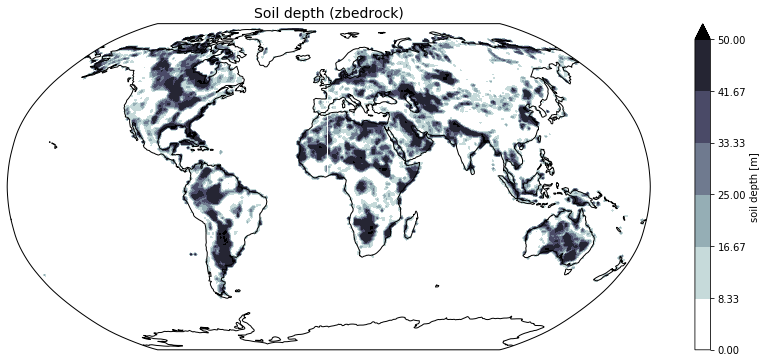

In [42]:
soil_depth = nc_zbedrock['zbedrock']
print("Maximum value is {} and minimum value is {}".format(np.amax(soil_depth),
                                                           np.amin(soil_depth)))
fig   = plt.figure(figsize=(16,6))
ax    = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
soil_depth.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0., vmax = 50.)
ax.set_title('Soil depth (zbedrock)', fontsize=14)
ax.set_global()
ax.coastlines()

### Plot 'TOTSOILLIQ'

### `It seems that we should not directly use TOTSOILLIQ, because the magnitude of 'TOTSOILLIQ' is very large, most regions exceed 500 kg/m2. `

Maximum value is <xarray.DataArray 'TOTSOILLIQ' ()>
array(4098.65722656) and minimum value is <xarray.DataArray 'TOTSOILLIQ' ()>
array(0.19998239)


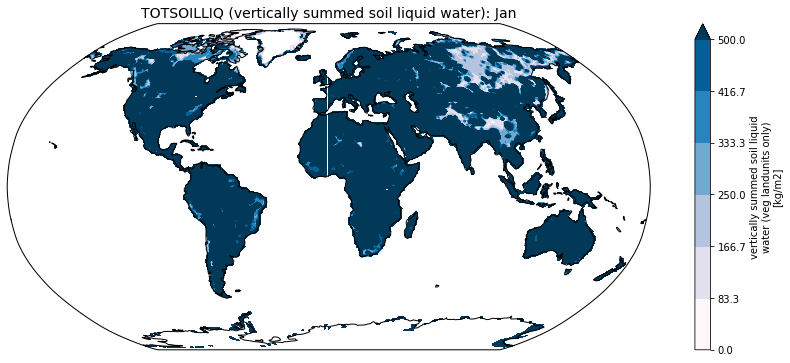

In [43]:
TOTSOILLIQ = nc_CLM['TOTSOILLIQ']
print("Maximum value is {} and minimum value is {}".format(np.amax(TOTSOILLIQ),
                                                           np.amin(TOTSOILLIQ)))
fig   = plt.figure(figsize=(16,6))
ax    = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
TOTSOILLIQ[0,:,:].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0., vmax = 500.)
ax.set_title('TOTSOILLIQ (vertically summed soil liquid water): Jan', fontsize=14)
ax.set_global()
ax.coastlines()

### Plot 'TOTSOILLIQ'/'ZBEDROCK'


Maximum value is <xarray.DataArray ()>
array(inf) and minimum value is <xarray.DataArray ()>
array(0.01723977)


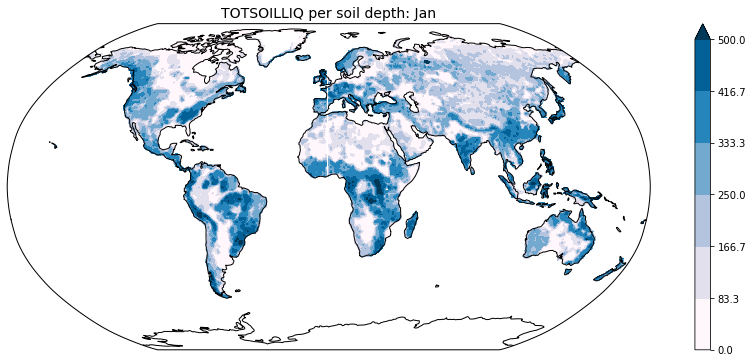

In [44]:
TOTSOILLIQ_per_zbedrock = TOTSOILLIQ / soil_depth

print("Maximum value is {} and minimum value is {}".format(np.amax(TOTSOILLIQ_per_zbedrock),
                                                           np.amin(TOTSOILLIQ_per_zbedrock)))
fig   = plt.figure(figsize=(16,6))
ax    = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
TOTSOILLIQ_per_zbedrock[0,:,:].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap = 'PuBu', vmin = 0., vmax = 500.)
ax.set_title('TOTSOILLIQ per soil depth: Jan', fontsize=14)
ax.set_global()
ax.coastlines()

### For now, we simply set the bucket depth = 200, following Lague et al. 2019. 

In [45]:
bucket_capacity = 200 # kg/m2
nc_data['bucketdepth'] = np.copy(bucket_capacity*stretch)

******
## D. deriving 'emissivity'

## `HOW TO:`
   * We follow Lague et al. 2019 and set emissivity to zero everywhere
   > The emissivity of the ground can be specified. Land surface emissivities range from 0.9 to 1.0 (Bonan, 2002); if unspecified, and for the purpose of this study, it is assumed that emissivity = 1 over all land areas.

In [27]:
nc_data['emissivity'] = np.copy(1.0*stretch)

## E. deriving 'snowmask'

## `HOW TO:`

### We calculate "snowmask" from "SNOW_DEPTH"

From Setion 1.3 of the supplementary material of Lague et al. 2019, quote, 
>"A typical value of Ms used in SLIM is 50 kg/m^2, which corresponds to roughly 25cm of snow (assuming a snow density of 200 kg/m3)."

So, we can obtain the "snowmask" by rho_snow * SNOW_DEPTH

### Q: I am really puzzled by the fact that unit of SNOW_DEPTH from CLM output is "m", and its value is quite large and reaches 20 to 30 meters in winter hemispheric polar region. This does not seem realistic. For now, I hold off this concern and proceed to calculate it anyway. But we should double check whether the magnitude is correct.
### A: My guess is they messed up the unit, it should be "mm" --> need to confirm with CLM people.


********* Plot of SNOW_DEPTH from CLIM output
Maximum value is <xarray.DataArray 'SNOW_DEPTH' ()>
array(33.65273285) and minimum value is <xarray.DataArray 'SNOW_DEPTH' ()>
array(0.)


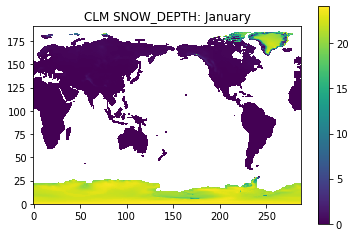

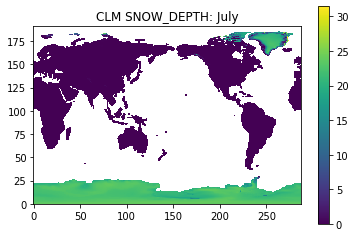

Maximum value is <xarray.DataArray 'SNOW_DEPTH' ()>
array(6730.54638672) and minimum value is <xarray.DataArray 'SNOW_DEPTH' ()>
array(0.)


In [47]:
print("********* Plot of SNOW_DEPTH from CLIM output")
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_CLM['SNOW_DEPTH']),
                                                           np.amin(nc_CLM['SNOW_DEPTH'])))
plt.imshow(nc_CLM['SNOW_DEPTH'][0,:,:], origin='lower'); plt.title('CLM SNOW_DEPTH: January'); plt.colorbar();plt.show();
plt.imshow(nc_CLM['SNOW_DEPTH'][6,:,:], origin='lower'); plt.title('CLM SNOW_DEPTH: July'); plt.colorbar();plt.show();

snow_density = 200 # kg/m3
nc_data['snowmask'] = nc_CLM['SNOW_DEPTH'] * snow_density
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_data['snowmask']),
                                                           np.amin(nc_data['snowmask'])))

## F. deriving 'roughness'
Roughness as "vegetation height" [m], which is then scaled down in the model as .1 * vegetation height for actual roughness used.

#### We follow Marysa's method to derive roughness, including (any REF for the choice of the values?)
<ul>
<li> set roughness in glacial regions to a constant (0.01)</li>
<li> set nans (if any) to 0.01 </li>
<li> set regions with very small roughness to 0.01 </li>
(Marysa commented that small roughness values mess up the turbulence calculation)
</ul>
    
#### What Marysa did additionally
She only takes the roughness from summer season, i.e. DJF from SH and JJA from NH. Then she combines the two summer hemispheres to a new globe, and assign the values to all 12 months. So the roughness she got is summer roughness for both hemisphere across the whole year. 

#### What we did differently from Marysa
<ul>
    <li> We consider the seasonality</li>
    <li> We did not consider snow free region</li>
</ul>

Deriving surface roughness
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray 'HTOP' ()>
array(31.66410255) and minimum value is <xarray.DataArray 'HTOP' ()>
array(0.)
******* Plot of HTOP (before smoothing) ******


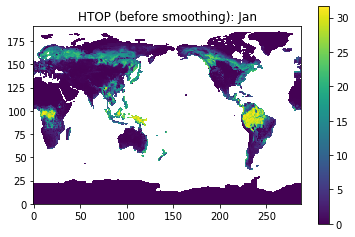

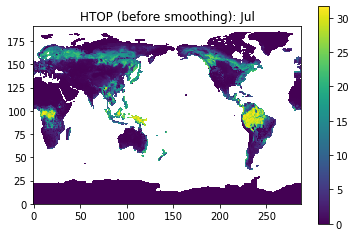

Setting these regions to 0.01: nans, small values, and glacial regions
Maximum value is 31.66410255432129 and minimum value is 0.009999999776482582
******* Plot of HTOP (after smoothing) ******


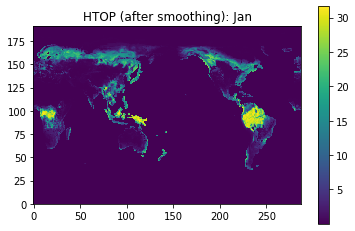

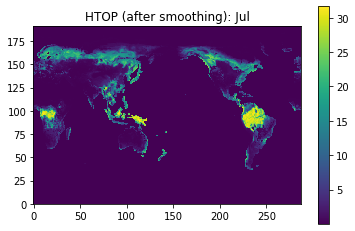

In [48]:
print("Deriving surface roughness")
##### set glacier roughness to 0.01
glc_hc = 0.01
#nc_hc  = {}

nc_data['roughness'] = nc_CLM['HTOP']
# Print the dimension 
print("Dimension is {} ".format(nc_data['roughness'].shape))
# Print the max and min for a quick sanity check
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_data['roughness']),
                                                           np.amin(nc_data['roughness'])))
print("******* Plot of HTOP (before smoothing) ******")
plt.imshow(nc_data['roughness'][0,:,:], origin='lower'); plt.title('HTOP (before smoothing): Jan'); plt.colorbar();plt.show();
plt.imshow(nc_data['roughness'][6,:,:], origin='lower'); plt.title('HTOP (before smoothing): Jul'); plt.colorbar();plt.show();

print("Setting these regions to 0.01: nans, small values, and glacial regions")
min_hc = 0.01
nc_data['roughness'] = np.where(np.isnan(nc_data['roughness']), min_hc, nc_data['roughness'])
nc_data['roughness'] = np.where(nc_data['roughness'] < min_hc, min_hc, nc_data['roughness'])
nc_data['roughness'] = np.where(glc_mask==1., glc_hc, nc_data['roughness'])
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_data['roughness']),
                                                           np.amin(nc_data['roughness'])))

print("******* Plot of HTOP (after smoothing) ******")
plt.imshow(nc_data['roughness'][0,:,:], origin='lower'); plt.title('HTOP (after smoothing): Jan'); plt.colorbar();plt.show();
plt.imshow(nc_data['roughness'][6,:,:], origin='lower'); plt.title('HTOP (after smoothing): Jul'); plt.colorbar();plt.show();

## G. deriving 'evap_res' 

### NOTE: 

#### There are two approaches to derive "evap_res", one is to follow what Marysa did, the other is to follow paper by [Yang et al., 2019](https://www.nature.com/articles/s41558-018-0361-0). In this notebook, we first follow the Marysa method, which was documented in section 5.2 of [Lague, 2019](https://marysalague.files.wordpress.com/2020/02/lague_phd_washington_2019.pdf).

#### We cap this value at 1000 s/m, following what Marysa did. 

Deriving evap_res
Dimension is (12, 192, 288) 
Maximum value is <xarray.DataArray ()>
array(inf) and minimum value is <xarray.DataArray ()>
array(1.927531e-06)
***** Plot without capping *****


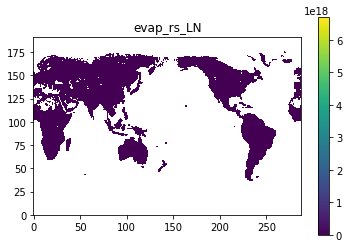

***** Capping the value at 1000 s/m *****
Maximum value is nan and minimum value is nan
Plot of evap_rs_LN after setting capped value = 1000.
It does look reasonable, though unclear at this point why I got nan for both maximum and minimum values.


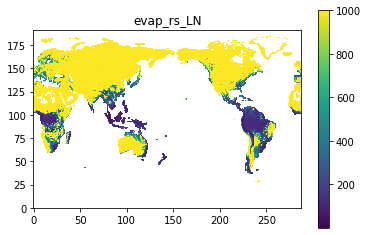

In [57]:
# GSSUNLN = sunlit leaf stomotal conductance at local noon (umol H2O/m2/s)
# GSSHALN = shaded leaf stomatal conductance at local noon (umol H2O/m2/s)
# LAISUN  = sunlit projected leaf area index (m^2/m^2)
# LAISHA  = shaded projected leaf area index (m^2/m^2)
print("Deriving evap_res")
nc_evap_res = {}
# unit conversion
gs_to_rs = 42.3*10**6 # umol H20/m2/s   to   s/m
sunLN    = nc_CLM['GSSUNLN'] * nc_CLM['LAISUN']
shaLN    = nc_CLM['GSSHALN'] * nc_CLM['LAISHA']

nc_evap_res['evap_rs_LN'] = gs_to_rs/(sunLN + shaLN)
nc_evap_res['evap_rs_LN'].attrs['units'] = 's/m'
nc_evap_res['evap_rs_LN'].attrs['longname'] = 'evaporative resistance at local noon = (42.3 x 10^6)/(gssunln*laisun+gsshaln*laisha)'

print("Dimension is {} ".format(nc_evap_res['evap_rs_LN'].shape))
# Print the max and min for a quick sanity check
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_evap_res['evap_rs_LN']),
                                                           np.amin(nc_evap_res['evap_rs_LN'])))
print("***** Plot without capping *****")

plt.imshow(nc_evap_res['evap_rs_LN'][0,:,:], origin='lower'); plt.title('evap_rs_LN'); plt.colorbar();plt.show();

print("***** Capping the value at 1000 s/m *****")
nc_evap_res['evap_rs_LN'] = np.where(nc_evap_res['evap_rs_LN'] > 1000., 1000., nc_evap_res['evap_rs_LN'])
#nc_evap_res['evap_rs_LN'].attrs['units'] = 's/m'
#nc_evap_res['evap_rs_LN'].attrs['longname'] = 'evaporative resistance at local noon capped at 1000 s/m; else = (42.3 x 10^6)/(gssunln*laisun+gsshaln*laisha)'

nc_data['evap_res'] = nc_evap_res['evap_rs_LN']
nc_data['evap_res'].shape
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_evap_res['evap_rs_LN']),
                                                           np.amin(nc_evap_res['evap_rs_LN'])))
print("Plot of evap_rs_LN after setting capped value = 1000.")
print("It does look reasonable, though unclear at this point why I got nan for both maximum and minimum values.")
plt.imshow(nc_evap_res['evap_rs_LN'][0,:,:], origin='lower'); plt.title('evap_rs_LN'); plt.colorbar();plt.show();

## H. deriving dust fluxes
    - l2xavg_Fall_flxdst1
    - l2xavg_Fall_flxdst2
    - l2xavg_Fall_flxdst3
    - l2xavg_Fall_flxdst4
    
### For now, we simply read in the DSTFLXT --> this is not we eventually want to do. 


In [50]:
### remove nans 
dust = nc_CLM['DSTFLXT'].values
dust = np.where(np.isnan(dust), 0.0, dust)

nc_data['l2xavg_Fall_flxdst1'] = dust 
nc_data['l2xavg_Fall_flxdst2'] = dust 
nc_data['l2xavg_Fall_flxdst3'] = dust 
nc_data['l2xavg_Fall_flxdst4'] = dust 



## I. deriving 'soil_type'
This variable is a placeholder, not currently used. Set to zero. 

In [51]:
print("Deriving soil type:")
nc_data['soil_type'] = np.copy(0.0*stretch)
print("Dimension is {} ".format(nc_data['soil_type'].shape))
print("Maximum value is {} and minimum value is {}".format(np.amax(nc_data['soil_type']),np.amin(nc_data['soil_type'])))

Deriving soil type:
Dimension is (12, 192, 288) 
Maximum value is 0.0 and minimum value is 0.0


## J. deriving soil thermal properties
    - soil_tk_1d
    - soil_cv_1d
### Suggestions from Marysa
> * Based on the PCT_CLAY, PCT_SAND (maybe also a silt and/or organic matter content?), ther are equations to determine what the thermal resistance/heat capacity of the soil are... There are a bunch of ways to calculate this, of varying complexity.
> * Table 15 in the LSM 1.0 tech note (precursor to CLM) has one of the simpler/most summarized versions of this, but you can also look at what CLM does (then use CLM's soil map). 

### CAVEAT: CLM's soil heat capacity varies with soil moisture, while that does NOT happen in SLIM. This means that when we run SLIM, we won't be able to capture the effects of changing soil moisture on the soil heat capacity, because the latter is prescribed.
  * Need to see literature on how the two are connected and whether this caveat is a big issue. 

## K. deriving glacier thermal properties
    - glc_tk_1d
    - glc_cv_1d

### For now, let's simply set a uniform value to soil_tk_1d, soil_cv_1d, glc_tk_1d, and glc_cv_1d. The values are from Marysa's values. Of course it is NOT what we want, but the goal is simply to make sure we can run the code sucessfully and save an input data. 

In [52]:
soil_cv_value = 2.0e6 # [J/m3/K]
soil_tk_value = 1.5   # [W/m/K]

glc_cv_value  = 1.9e6 # [J/m3/K]
glc_tk_value  = 2.4   # [W/m/K]

nc_data['soil_cv_1d'] = np.copy(soil_cv_value*stretch)
nc_data['soil_tk_1d'] = np.copy(soil_tk_value*stretch)
nc_data['glc_cv_1d']  = np.copy(glc_cv_value*stretch)
nc_data['glc_tk_1d']  = np.copy(glc_tk_value*stretch)

### Put all the vars into an xarray dataset

In [58]:
# Define a time vector for months 1-12
time_vector = range(13)[1:13]

attrs = {'Units'}

nc_SLIM = {}

nc_SLIM = xr.Dataset({'glc_mask': (['time','lsmlat','lsmlon'],nc_data['glc_mask']),
                     'alb_gvd':(['time','lsmlat','lsmlon'],nc_data['alb_gvd']),
                     'alb_svd':(['time','lsmlat','lsmlon'],nc_data['alb_svd']),
                     'alb_gnd':(['time','lsmlat','lsmlon'],nc_data['alb_gnd']),
                     'alb_snd':(['time','lsmlat','lsmlon'],nc_data['alb_snd']),
                     'alb_gvf':(['time','lsmlat','lsmlon'],nc_data['alb_gvf']),
                     'alb_svf':(['time','lsmlat','lsmlon'],nc_data['alb_svf']),
                     'alb_gnf':(['time','lsmlat','lsmlon'],nc_data['alb_gnf']),
                     'alb_snf':(['time','lsmlat','lsmlon'],nc_data['alb_snf']),
                     'bucketdepth':(['time','lsmlat','lsmlon'],nc_data['bucketdepth']),
                     'emissivity':(['time','lsmlat','lsmlon'],nc_data['emissivity']),
                     'snowmask':(['time','lsmlat','lsmlon'],nc_data['snowmask']), 
                     'roughness':(['time','lsmlat','lsmlon'],nc_data['roughness']),
                     'evap_res':(['time','lsmlat','lsmlon'],nc_data['evap_res']),
                     'l2xavg_Fall_flxdst1':(['time','lsmlat','lsmlon'],nc_data['l2xavg_Fall_flxdst1']),
                     'l2xavg_Fall_flxdst2':(['time','lsmlat','lsmlon'],nc_data['l2xavg_Fall_flxdst2']),
                     'l2xavg_Fall_flxdst3':(['time','lsmlat','lsmlon'],nc_data['l2xavg_Fall_flxdst3']),
                     'l2xavg_Fall_flxdst4':(['time','lsmlat','lsmlon'],nc_data['l2xavg_Fall_flxdst4']),
                     'soil_type':(['time','lsmlat','lsmlon'],nc_data['soil_type']),
                     'soil_tk_1d':(['time','lsmlat','lsmlon'],nc_data['soil_tk_1d']),
                     'soil_cv_1d':(['time','lsmlat','lsmlon'],nc_data['soil_cv_1d']),
                     'glc_tk_1d':(['time','lsmlat','lsmlon'],nc_data['glc_tk_1d']),
                     'glc_cv_1d':(['time','lsmlat','lsmlon'],nc_data['glc_cv_1d'])},
                     coords = {'lsmlon': (['lsmlon'],lon_clm),
                               'lsmlat': (['lsmlat'],lat_clm), 
                                'time': (['time'],time_vector)},
                     attrs = {'Author':'WK modified from MML', 
                              'Date_created':tm.strftime("%Y-%m-%d %H:%M:%S")+' '+tm.tzname[0]+' '+tm.tzname[1],
                              'Resolution':'f09_f09',
                              'Description':'Forcing File for simple land model',
                              'domains_mask_file':f_domain,
                              'ccesm_source_run':casename,
                              ###### dust_file currently commented #####
                              ###### Still in progress...in deciding the dust #####
                              #'dust_file':dust_file,
                              'surfdat_file_for_glc_mask':f_surfdata,
                             })

    # Define units of each variable, and map them onto the dataset
    #ds.attrs['Units']=''

unit_map = {'glc_mask':'unitless','alb_gvd':'unitless','alb_svd':'unitless',
                'alb_gnd':'unitless','alb_snd':'unitless','alb_gvf':'unitless',
                'alb_svf':'unitless','alb_gnf':'unitless','alb_snf':'unitless',
                'bucketdepth':'kg/m2','emissivity':'unitless','snowmask':'kg/m2',
                'roughness':'m','evap_res':'s/m',
                'l2xavg_Fall_flxdst1':'unknown', 'l2xavg_Fall_flxdst2':'unknown', 
                'l2xavg_Fall_flxdst3':'unknown', 'l2xavg_Fall_flxdst4':'unknown', 
                'soil_type':'unknown', 'soil_tk_1d':'W/m/K', 'soil_cv_1d':'J/m3/K', 
                'glc_tk_1d':'W/m/K', 'glc_cv_1d':'J/m3/K','lsmlat':'degrees north',
                'lsmlon':'degrees east','time':'month'}

for var in nc_SLIM:
       if var in unit_map:
            nc_SLIM[var].attrs['Units'] = unit_map[var]
            nc_SLIM[var].attrs['_FillValue'] = 9.99e20
            
nc_SLIM['lsmlon'].attrs['_FillValue'] = False
nc_SLIM['lsmlat'].attrs['_FillValue'] = False

### Save the SLIM input dataset 

In [59]:
save_to_path = './'
nc_SLIM.to_netcdf(path=save_to_path + 'slim_fromCMIP6-AMIP_ensemble001_1991to2010clim_'+tm.strftime("%Y%m%d")+'.nc',
                 format = 'NETCDF3_64BIT')